# Audio Retrieval MS2
This project focuses on audio retrieval using constellation maps, inspired by prior work on audio fingerprinting and matching (Please see the `README.md` in the Acknowledgements/Credits section for more information). Milestone 2 builds on the work done in Milestone 1. In Milestone 1 we used a naive approach to find matches between queries and the database. In Milestone 2 we will optimize the system to handle a larger dataset and queries. 

1. First, following the work of Wang, we will implement a function that generates hashes for the database and queries. These hashes will be used to find matches between the queries and the database. We will then optimize the system to handle a larger dataset and queries. Hashes are much faster and could yield a better result than the naive approach we used in Milestone 1. 
The hashing is done with a target zone approach. We will define 4 different target zones and compare the storage requirements for each.

2. We will redo the evaluation of the queries done in Milestone 1. We will compare retrieval performance (efficiency,
query times) for all four configurations and all types of queries individually and combined. 

3. We will scale up the system. In Milestone 1 we only considered the tarball 04 with 556 files. For Milestone 2 we want to consider 61 tarballs. Please look into the `data` folder for the script to automatically download the tarballs if you want to reproduce the results. We used the compressed tarballs but still ended up with a dataset of around 100GB and 33966 files. We will report on performance with increasing database size.


For this milestone you can again reproduce our results by running the code in the nodebook. Please remember that downloading and computing (especially the task 3) will take some time. Our results are based on the system described by the `README.md` file in the `evaluation` folder. If you do not have the capacity to compute the hashes for task 1 and 2 you can load the hashes located in the `hashes` folder. How to do this is described later in the notebook in task 1. 

# Task 1: Hash Generation and Storage
We chose the best performing configurations for our constellation map as evaluated in Milestone 1.  

In [3]:
configuration = (8, 2) # (κ=8, τ=2)
(dist_freq, dist_time) = configuration

Now let's define some helper methods that we know from Milestone 1 to generate the database and query datastructures. The code is similar to the one used in Milestone 1 with a few optimizations, like threading and parallel processing for the database. This will be helpful when computing the constellation maps for the database in step 3. The computation of the query constellation maps will not be changed as we only have a few queries and the computation time is not so critical.

In [39]:
import os
import numpy as np
import librosa
from scipy import ndimage
import matplotlib.pyplot as plt
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

def get_files(directory='../data', endswith='.wav'):
    """Function to get all files with the specified extension in a directory and its subdirectories."""
    files = []
    for root, _, fs in os.walk(directory):
        for f in fs:
            if f.endswith(endswith) and not f.startswith('.'):
                files.append(os.path.join(root, f))
    return files

def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map from a spectrogram Y."""
    result = ndimage.maximum_filter(Y, size=[2 * dist_freq + 1, 2 * dist_time + 1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """Compute spectrogram for a given audio file"""
    x, Fs = librosa.load(fn_wav, sr=Fs)
    #if len(x) < N:
        # Padding with zeros to ensure min length.
    #    x = np.pad(x, (0, N - len(x)))
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

def process_file_prepare_database(file, configuration, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    # Compute spectrogram for the current file
    Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

    # Initialize nested structure for the current file
    #file_key = os.path.basename(file)
    file_key = re.split(r'[\\/]', file)[-1]
    (dist_freq, dist_time) = configuration

    # Compute constellation maps
    cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)

    return file_key, cmap


def prepare_database_parallel(file_list, configuration, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    database = {}
    print(f"Processing {len(file_list)} files in parallel...")

    # Parallelisierung mit ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(
            executor.map(
                lambda file: process_file_prepare_database(file, configuration, Fs, N, H, bin_max, frame_max), file_list
            )
        )

    for file_key, data in results:
        database[file_key] = data

    print("Processing done.")
    return database

def prepare_query_constellation_maps(file_list, configuration, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """Compute query constellation maps for all configurations and save the results in a nested structure."""
    query_maps = {}
    for file in file_list:

        # Compute spectrogram for the current file
        Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

        # Retrieve metadata for the file
        file_size = os.path.getsize(file)  # Size in bytes

        # Initialize nested structure for the current query
        file_key = os.path.basename(file)
        query_maps[file_key] = {
            "metadata": {
                "size": file_size,
                "original_query_id": file_key.split('_')[0],
            },
            "constellation_map": {}
        }

        # Compute constellation maps for all configurations
        (dist_freq, dist_time) = configuration
        cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
        query_maps[file_key]["constellation_map"] = cmap
    return query_maps


def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map on top of a spectrogram"""
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5 / Fs, (N - 0.5) / Fs]
    if ylim is None:
        ylim = [-0.5 / Fs, (K - 0.5) / Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im

Now with this code we have everything we need to prepare the database and queries. Let's do it.

In [5]:
import time
database_files = get_files(directory='../data/04', endswith='.mp3')
start_time = time.perf_counter()
database = prepare_database_parallel(database_files, configuration)
print (f"Time to compute constellation maps for the database: {time.perf_counter() - start_time:.2f} seconds")

Processing 556 files in parallel...
Processing done.
Time to compute constellation maps for the database: 92.02 seconds


In [6]:
query_list_original = get_files(directory='../queries/cut_output', endswith=".wav")
query_list_noise = get_files(directory='../queries/noise_output', endswith=".wav")
query_list_coding = get_files(directory='../queries/coding_output', endswith=".wav")
query_list_mobile = get_files(directory='../queries/mobile_output', endswith=".wav")


query_C_original = prepare_query_constellation_maps(query_list_original, configuration)
query_C_noise = prepare_query_constellation_maps(query_list_noise, configuration)
query_C_coding = prepare_query_constellation_maps(query_list_coding, configuration)
query_C_mobile = prepare_query_constellation_maps(query_list_mobile, configuration)

Perfect, let's see if the computing of constellation maps worked.

(<Figure size 504x216 with 1 Axes>,
 <Axes: title={'center': 'Constellation Map for 1009604_cut.wav (κ=8, τ=2)'}, xlabel='Time (sample)', ylabel='Frequency (bins)'>,
 <matplotlib.image.AxesImage at 0x1a6daa5fb00>)

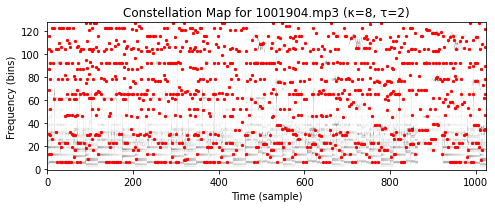

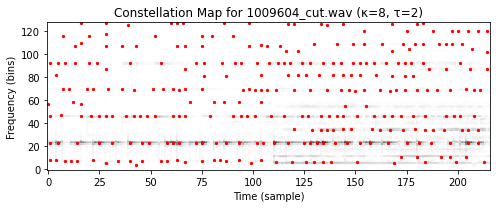

In [7]:
first_file_database = database_files[0]
Y = compute_spectrogram(first_file_database, Fs=22050, N=2048, H=1024, bin_max=128)
cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
title = f"Constellation Map for {os.path.basename(first_file_database)} (κ={dist_freq}, τ={dist_time})"
plot_constellation_map(cmap, Y=Y, title=title)

first_file_query = query_list_original[0]
Y = compute_spectrogram(first_file_query, Fs=22050, N=2048, H=1024, bin_max=128)
cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
title = f"Constellation Map for {os.path.basename(first_file_query)} (κ={dist_freq}, τ={dist_time})"
plot_constellation_map(cmap, Y=Y, title=title)

Great, now we can move on to the next step: Hash generation. Following the work of Wang, we will generate hashes for the database and the queries. These hashes will be used to find matches between the queries and the database. To organize and retrieve these hashes, we use an inverted index. This structure maps each unique hash to the list of tracks in which it appears, along with their respective timing information. By using an inverted index, we can significantly speed up the search process, as it eliminates the need for sequentially scanning all tracks, which would be the disadvantage of storing the hashes in a list. Unlike probabilistic methods such as MinHash, the inverted index provides exact matches, ensuring high precision in our results. MinHash could be considered for future work to improve scalability for even larger databases (> 100 GB).


Will compare storage requirements and computation time for four different target zones. 
First let's define the target zones. Target zones are used to define the range of frequency and time offsets to consider when computing the hashes. They are defined by the time min and max offset and frequency min and max offset. With these parameters we define a rectangle in the constellation map that we consider for the hash generation. Consider `time_min_offset=5, time_max_offset=20, freq_min_offset=-10, freq_max_offset=10`. This means that the target_zone will start 5 time frames after the anchor point and end 20 time frames after the anchor point. The frequency range is 10 bins above and below the anchor point. This means that we consider a time window of 15 frames and a frequency range of 20 bins. 
 
Alternatives could be to use a fixed number of target candidates per anchor point or to use a combination of both. Additionally, we assigned to each target_zone an id, which is a tuple of the dist_freq and dist_time. This will help us to identify the target zone later on.

Since our configuration of the constellation map generates many points (anchors) we will define a rather small and a medium size of the target zone. These values were initially chosen based on educated guesses and further refined through experimentation with different configurations. The final parameters, which we determined to be most suitable for evaluation, are as follows:

In [8]:
target_zones = [ 
    { 
        "id" : (5, 20),
        "time_min_offset": 1, # time window of 5, frequency range of 20
        "time_max_offset": 6,
        "freq_min_offset": -10,
        "freq_max_offset": 10
    },
    {
        "id" : (5, 40),
        "time_min_offset": 5, # time window of 5, frequency range of 40
        "time_max_offset": 10,
        "freq_min_offset": 0,
        "freq_max_offset": 40
    },
    {
        "id" : (10, 20),
        "time_min_offset": 1, # time window of 10, frequency range of 20
        "time_max_offset": 11,
        "freq_min_offset": -10,
        "freq_max_offset": 10
    },
    {
        "id" : (10, 40),
        "time_min_offset": 5, # time window of 10, frequency range of 40
        "time_max_offset": 15,
        "freq_min_offset": -20,
        "freq_max_offset": 20
    }
]


Perfect, now let's define a hash generation function. As described earlier, we store the hashes for the database in an inverted index. We also write a function to compute the hashes for the queries. 

In [9]:
def compute_hashes_index(files_dict, target_zone):
    db_hash_index = defaultdict(list)
    time_min_offset = target_zone["time_min_offset"]
    time_max_offset = target_zone["time_max_offset"]
    freq_min_offset = target_zone["freq_min_offset"]
    freq_max_offset = target_zone["freq_max_offset"]

    for file_name, constellation_map in files_dict.items():
        freq_bins, time_bins = np.where(constellation_map == 1)
        #print(f"Processing {file_name}, freq bins: {freq_bins.size}")
        
        # Pre-sort the constellation points by time for efficient pairing
        points = sorted(zip(freq_bins, time_bins), key=lambda x: x[1])
        
        for i, (freq1, time1) in enumerate(points):
            for j in range(i+1, len(points)):
                freq2, time2 = points[j]
                delta_time = time2 - time1
                
                # Stop further comparisons if delta_time exceeds time_max_offset
                if delta_time > time_max_offset:
                    break
                
                if delta_time >= time_min_offset:
                    hash_value = compute_hash(
                        freq1, freq2, delta_time, 
                        time_min_offset, time_max_offset, 
                        freq_min_offset, freq_max_offset
                    )
                    if hash_value is not None:
                        db_hash_index[np.uint32(hash_value)].append((file_name, time1))
        
        #print(f"Finished hashing {file_name}")

    return db_hash_index

def compute_hash(freq1, freq2, delta_time, time_min_offset, time_max_offset, freq_min_offset, freq_max_offset):
    if (
            time_min_offset <= delta_time <= time_max_offset and
            freq2 >= 0 and
            freq1 + freq_max_offset > freq2 > freq1 + freq_min_offset
    ):
        # Compute 32-bit hash as described in Wang's paper
        hash_value = (
                (freq1 & 0x3FF) << 22 |  # 10 bits for freq1
                (freq2 & 0x3FF) << 12 |  # 10 bits for freq2
                (delta_time & 0xFFF)  # 12 bits for delta_time
        )
        return hash_value
    return None

def compute_hashes_for_query(constellation_map, target_zone):
    hashes_list = []
    time_min_offset = target_zone["time_min_offset"]
    time_max_offset = target_zone["time_max_offset"]
    freq_min_offset = target_zone["freq_min_offset"]
    freq_max_offset = target_zone["freq_max_offset"]

    # Extract and sort anchor points by time
    freq_bins, time_bins = np.where(constellation_map == 1)
    points = sorted(zip(freq_bins, time_bins), key=lambda x: x[1])

    for i, (freq1, time1) in enumerate(points):
        for j in range(i+1, len(points)):
            freq2, time2 = points[j]
            delta_time = time2 - time1
            
            # Break if delta_time exceeds the allowed maximum
            if delta_time > time_max_offset:
                break
            
            if delta_time >= time_min_offset:
                hash_value = compute_hash(
                    freq1, freq2, delta_time, 
                    time_min_offset, time_max_offset, 
                    freq_min_offset, freq_max_offset
                )
                if hash_value is not None:
                    hashes_list.append((np.uint32(hash_value), time1))

    return hashes_list

After computing the hashes we want to get some information on the storage requirements. For this we will define some methods that help us with that. Additionally, we will define a method that lets us store the hashes in a file and load them from a file. To do this we will use the `pickle` library and since our index is a `defaultdict(list)` we can serialize it directly and do not need to convert it to for example a JSON object, which would be less efficient. To compute the size of the object in memory we will use the `pympler` library, which is a memory profiler for Python.

In [10]:
from pympler import asizeof
import pickle
import os
import pympler

def save_db_hash_index(db_hash_index, file_path='db_hash_index.pkl'):
    """Saves the db_hash_index in a file"""
    directory = os.path.dirname(file_path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(file_path, 'wb') as f:
        pickle.dump(db_hash_index, f)
    print(f"saved db_hash_index in {file_path}")

def load_db_hash_index(file_path='db_hash_index.pkl'):
    """Loads the db_hash_index from a file."""
    with open(file_path, 'rb') as f:
        db_hash_index = pickle.load(f)
    print(f"loaded db_hash_index from {file_path}")
    return db_hash_index

import sys
def get_sizeof(obj):
    """Calculates the size of an object recursively."""
    return asizeof.asizeof(obj)

Ok now let's try to compute the hashes for the database and the queries. 

We will compute the index for every target zone and use the defined methods to check on the storage requirements. We will also measure the time it takes to compute the hashes and combine the results in a table.

In [12]:
import time
import os
import pickle
from pandas import DataFrame
from IPython.display import display

def compute_and_save(db_hash_index, target_zone, file_path):
    start_time = time.perf_counter()
    db_hash_index = compute_hashes_index(database, target_zone)
    compute_time = time.perf_counter() - start_time
    
    # Save to file
    save_db_hash_index(db_hash_index, file_path)
    
    # Get sizes
    in_memory_size = get_sizeof(db_hash_index)
    on_storage_size = os.path.getsize(file_path)
    
    return compute_time, in_memory_size, on_storage_size

# List to store results
results = []

# Compute and store for each target zone
for i, target_zone in enumerate(target_zones):
    print(f"Computing and storing for target zone {i}...")
    file_path = f'hashes/db_hash_index_tz{i}.pkl'
    compute_time, in_memory_size, on_storage_size = compute_and_save(
        db_hash_index=f'db_hash_index_tz{i}', 
        target_zone=target_zone,  
        file_path=file_path
    )
    results.append({
        "Target Zone (dist_time, dist_freq)": f"{target_zone['id']}",
        "Compute Time (s)": compute_time,
        "In-Memory Size (MB)": in_memory_size / (1024**2),
        "On-Storage Size (MB)": on_storage_size / (1024**2),
    })

# Convert results to a DataFrame
df = DataFrame(results)

# Style the DataFrame for better visual appearance
styled_df = (
    df.style
    .set_properties(**{'text-align': 'left', 'border': '1px solid black'})
    .set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'left'), ('background-color', '#f4f4f4')]},
        {'selector': 'td', 'props': [('padding', '8px')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f0f0f0')]},
    ])
    .set_caption("Summary of Retrieval Metrics")
    .format(na_rep="-")  # Replace missing values with '-'
    .format({
        "Compute Time (s)": "{:.2f}",  # Format compute time with 2 decimal places
        "In-Memory Size (MB)": "{:.2f}",  # Format in-memory size with 2 decimal places
        "On-Storage Size (MB)": "{:.2f}"  # Format on-storage size with 2 decimal places
    })
)

# Display the styled DataFrame in the notebook
display(styled_df)


Computing and storing for target zone 0...
saved db_hash_index in hashes/db_hash_index_tz0.pkl
Computing and storing for target zone 1...
saved db_hash_index in hashes/db_hash_index_tz1.pkl
Computing and storing for target zone 2...
saved db_hash_index in hashes/db_hash_index_tz2.pkl
Computing and storing for target zone 3...
saved db_hash_index in hashes/db_hash_index_tz3.pkl


,"Target Zone (dist_time, dist_freq)",Compute Time (s),In-Memory Size (MB),On-Storage Size (MB)
0,"(5, 20)",3.07,39.27,10.13
1,"(5, 40)",4.39,86.10,19.73
2,"(10, 20)",5.21,78.87,18.81
3,"(10, 40)",7.81,172.37,36.02


The table summarizes retrieval metrics for different target zones, showing compute time, in-memory size, and on-storage size. The in-memory size of the db_hash_index is significantly larger than the on-storage size due to the overhead of Python’s dictionary structure. In memory, additional storage is required for hash tables, pointers, and metadata to ensure fast access and efficient manipulation. In contrast, the on-storage size represents a serialized version of the data, where pickle eliminates this overhead and stores only the compact data structure. This explains why the serialized .pkl file is much smaller, as it does not include runtime metadata or dynamic allocation buffers.

Other than that everything is reasonable. Of course the larger the target zone, the more hashes we will have, the longer it takes to compute, and the more storage we will need. 


If you already have the hashes computed or if you want to use the hashes we computed you can load them from the `hashes` folder. To do this execute the following code. Please also execute this code to load the hashes for the retrieval experiments in the following task.

In [13]:
db_hash_index_tz0 = load_db_hash_index('hashes/db_hash_index_tz0.pkl')
db_hash_index_tz1 = load_db_hash_index('hashes/db_hash_index_tz1.pkl')
db_hash_index_tz2 = load_db_hash_index('hashes/db_hash_index_tz2.pkl')
db_hash_index_tz3 = load_db_hash_index('hashes/db_hash_index_tz3.pkl')

loaded db_hash_index from hashes/db_hash_index_tz0.pkl
loaded db_hash_index from hashes/db_hash_index_tz1.pkl
loaded db_hash_index from hashes/db_hash_index_tz2.pkl
loaded db_hash_index from hashes/db_hash_index_tz3.pkl


# Task 2: Audio Identification
In this task we will repeat the retrieval experiment from Milestone 1, this time using the hash representation and storage. We use the matching strategy described in the reference paper to find the best match. The basic idea of the matching process is to compute the hashes from the query using the same method applied during the preparation of the database. These hashes are then compared against the database hashes, and the track with the highest number of consecutive matching hashes is selected as the best result.

To do this we will need a matching function:

In [15]:
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

def match_query_to_database(query_hash_list, db_hash_index):
    results = defaultdict(lambda: defaultdict(int))
    for query_hash, query_time in query_hash_list:
        if query_hash in db_hash_index:
            for db_track_id, db_time in db_hash_index[query_hash]:
                delta_offset = db_time - query_time
                results[db_track_id][delta_offset] += 1    
    best_track = None
    best_count = 0
    
    for track_name, offset_counts in results.items():
        for delta_offset, count in offset_counts.items():
            if count > best_count:
                best_count = count
                best_track = track_name
                
    return {
        "track_id": best_track,
        "score": best_count,
    }


Nice, let's test it with a query and see if it works. We will use target zone 0 for this.

In [16]:
fst_query = query_C_original['1009604_cut.wav']['constellation_map']
query_hash_list = compute_hashes_for_query(fst_query, target_zones[0])

time_now = time.perf_counter()
print("Now matching query to database threaded")
result = match_query_to_database(query_hash_list, db_hash_index_tz0)
print("Threaded Matching took", time.perf_counter()-time_now, "seconds")

# print result
if result["track_id"]:
    print(f"Best Match: {result['track_id']}")
    print(f"Score: {result['score']}")
    #print(f"Delta-T Histogram: {result['delta_t_histogram']}")
else:
    print("No significant match found.")

Now matching query to database threaded
Threaded Matching took 0.046735700001590885 seconds
Best Match: 1009604.mp3
Score: 89


ok perfect, it seems to work. Now we can try to match all the queries (cut, noise, coding, and mobile) and record the results. 
Let's do this also for all the target zone settings available and compare the results in a table.

In [23]:
from pandas import DataFrame

def compute_all_hashes_for_queries(query_constellation_maps, target_zones):
    all_hashes = {}
    for target_zone in target_zones:
        target_zone_hashes = {}
        for query_type, queries in query_constellation_maps.items():
            type_hashes = {}
            for query_name, query_data in queries.items():
                constellation_map = query_data["constellation_map"]
                hashes = compute_hashes_for_query(constellation_map, target_zone)
                type_hashes[query_name] = hashes
            target_zone_hashes[query_type] = type_hashes
        all_hashes[target_zone['id']] = target_zone_hashes
    return all_hashes


def perform_retrieval_experiments(all_query_hashes, db_hash_index):
    results = {}
    total_start_time = time.perf_counter()

    for query_type, queries in all_query_hashes.items():
        type_results = []
        correct_matches = 0
        total_queries = 0
        start_time_query_type = time.perf_counter()
        
        for query_name, query_hash_list in queries.items():
            query_start_time = time.perf_counter()

            # Perform matching
            result = match_query_to_database(query_hash_list, db_hash_index)
            query_time = time.perf_counter() - query_start_time

            # Check if the match is correct
            is_correct = result["track_id"].split('.')[0] == query_name.split('_')[0] if result["track_id"] else False

            if is_correct:
                correct_matches += 1
            #else:
                #print(f"Wrong Result: Query {query_name} matched to {result['track_id']} with score {result['score']}")

            # Store individual query results
            type_results.append({
                "query_name": query_name,
                "best_match": result["track_id"],
                "score": result["score"],
                "query_time": query_time,
                "correct": is_correct
            })
            total_queries += 1
        end_time_query_type = time.perf_counter()
        # Calculate accuracy for this query type
        results[query_type] = {
            "query_results": type_results,
            "correct_matches": correct_matches,
            "total_queries": total_queries,
            "accuracy": correct_matches / total_queries if total_queries > 0 else 0,
            "time": end_time_query_type - start_time_query_type,
            "average_query_time": (end_time_query_type - start_time_query_type) / total_queries if total_queries > 0 else 0
        }

    total_time = time.perf_counter() - total_start_time
    print(f"Total Retrieval Experiments Time: {total_time:.2f} seconds")
    return results


def save_results_to_table(results):
    summary_data = []
    for query_type, result in results.items():
        summary_data.append({
            "Query Type": query_type,
            "Correct Matches": result["correct_matches"],
            "Total Queries": result["total_queries"],
            "Accuracy": result["accuracy"],
            "Time for all Queries (s)": result["time"],
            "Average Query Time (s)": result["average_query_time"]
        })
    summary_df = DataFrame(summary_data)
    return summary_df


In [24]:
all_query_hashes = compute_all_hashes_for_queries(
    query_constellation_maps={
        "original": query_C_original,
        "noise": query_C_noise,
        "coding": query_C_coding,
        "mobile": query_C_mobile
    },
    target_zones=target_zones
)

In [25]:
results_tz0 = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[0]['id']],
    db_hash_index=db_hash_index_tz0
)
summary_table_tz0 = save_results_to_table(results_tz0)
display(summary_table_tz0)

Total Retrieval Experiments Time: 1.44 seconds


,Query Type,Correct Matches,Total Queries,Accuracy,Time for all Queries (s),Average Query Time (s)
0,original,20,20,1.00,0.393448,0.019672
1,noise,19,20,0.95,0.378066,0.018903
2,coding,19,20,0.95,0.401751,0.020088
3,mobile,9,20,0.45,0.262950,0.013147


In [26]:
results_tz1 = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[1]['id']],
    db_hash_index=db_hash_index_tz1
)
summary_table_tz1 = save_results_to_table(results_tz1)
display(summary_table_tz1)

Total Retrieval Experiments Time: 1.78 seconds


,Query Type,Correct Matches,Total Queries,Accuracy,Time for all Queries (s),Average Query Time (s)
0,original,20,20,1.00,0.464886,0.023244
1,noise,20,20,1.00,0.489440,0.024472
2,coding,19,20,0.95,0.470757,0.023538
3,mobile,15,20,0.75,0.358442,0.017922


In [27]:
results_tz2 = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[2]['id']],
    db_hash_index=db_hash_index_tz2
)
summary_table_tz2 = save_results_to_table(results_tz2)
display(summary_table_tz2)

Total Retrieval Experiments Time: 3.19 seconds


,Query Type,Correct Matches,Total Queries,Accuracy,Time for all Queries (s),Average Query Time (s)
0,original,20,20,1.00,0.917624,0.045881
1,noise,19,20,0.95,0.843951,0.042198
2,coding,19,20,0.95,0.869375,0.043469
3,mobile,11,20,0.55,0.559538,0.027977


In [28]:
results_tz3 = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[3]['id']],
    db_hash_index=db_hash_index_tz3
)
summary_table_tz3 = save_results_to_table(results_tz3)
display(summary_table_tz3)

Total Retrieval Experiments Time: 5.73 seconds


,Query Type,Correct Matches,Total Queries,Accuracy,Time for all Queries (s),Average Query Time (s)
0,original,20,20,1.00,1.667002,0.083350
1,noise,19,20,0.95,1.478416,0.073921
2,coding,20,20,1.00,1.539459,0.076973
3,mobile,18,20,0.90,1.048589,0.052429


The retrieval experiments were conducted across four different target zones, each defined by varying dist_time and dist_freq parameters. These parameters influence the size of the constellation map and the number of generated hashes. As expected, larger target zones produced more hashes, increasing the likelihood of identifying the correct track but also requiring more computational time.

The results demonstrate that the last configuration (dist_time=10, dist_freq=40) provided the highest accuracy, especially for distorted queries such as "mobile" and "coding." Its larger hash pool enhances robustness against query distortions, achieving 90% accuracy for "mobile" recordings. However, this comes at the cost of longer retrieval times and particularly higher space requirements. In contrast, Zone 0 (dist_time=5, dist_freq=20) showed lower accuracy for the mobile queries but delivered really well for the other query types. Additionally, it was the fastest configuration with the lowest space requirements.

Zone 1 and 2 also did quite well for all types but the "mobile" version. The "mobile" queries are the most distorted and therefore the hardest to match.

The results suggest that the best choice of target zone depends on the specific requirements of the application. If for your use case "mobile" queries are the exception than the first configuration might be the best choice. If you have a lot of "mobile" queries you might want to go with the last configuration. We are assuming that "mobile" queries are relevant, and thus we will go with the last configuration for the next task.

To further improve the retrieval performance, even larger target zones could be considered but this would come at the cost of increased computational time and storage requirements.

# Task 3: Scale Up
We will scale up the system. In Milestone 1 we only considered the tarball 04 with approximately 556 files. For Milestone 2 we want to consider 61 tarballs. 

For this we download a few more tarballs from MTG-Jamendo. Let's download additional 60 tarballs and extract them in the `data` folder to see if the system can handle the increased load. We will report on performance with increasing database size.

For downloading the dataset you may use the script located in the `data` folder. 
Attention: In total the dataset is around 100GB large.

Let's define some function to help us with the scaling up process. We now also do not store the constellation maps in memory but directly compute the hashes to save memory. 

In [30]:
def prepare_hash_index_parallel(file_list, configuration, target_zone, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """
    Process files in parallel to create a hash index without storing the constellation maps.

    Parameters:
    - file_list (list): List of file paths to process.
    - configuration (tuple): Configuration for constellation map (dist_freq, dist_time).
    - target_zone (tuple): Target zone for hash computation (dist_freq, dist_time).
    - exclusion_zone (int): Exclusion zone for anchor points.
    - Fs, N, H, bin_max, frame_max: Parameters for spectrogram computation.

    Returns:
    - db_hash_index (dict): Hash index with {hash_value: [(file_name, time1), ...]}.
    """
    db_hash_index = defaultdict(list)
    print(f"Processing {len(file_list)} files in parallel...")
    progress_counter = 0 
    total_files = len(file_list)

    def process_file(file):
        """Process a single file to compute hashes."""
        nonlocal progress_counter
        try:
            # Compute spectrogram
            Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)
            file_key = re.split(r'[\\/]', file)[-1]
            dist_freq, dist_time = configuration

            # Compute constellation map
            cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)

            time_min_offset = target_zone["time_min_offset"]
            time_max_offset = target_zone["time_max_offset"]
            freq_min_offset = target_zone["freq_min_offset"]
            freq_max_offset = target_zone["freq_max_offset"]
            # Compute hashes from constellation map
            freq_bins, time_bins = np.where(cmap == 1)  # Anchor points
            points = sorted(zip(freq_bins, time_bins), key=lambda x: x[1])
            local_hash_index = defaultdict(list)

            for i, (freq1, time1) in enumerate(points):
                for j in range(i+1, len(points)):
                    freq2, time2 = points[j]
                    delta_time = time2 - time1
                    
                    # Break if delta_time exceeds the allowed maximum
                    if delta_time > time_max_offset:
                        break
                    
                    if delta_time >= time_min_offset:
                        hash_value = compute_hash(
                            freq1, freq2, delta_time, 
                            time_min_offset, time_max_offset, 
                            freq_min_offset, freq_max_offset
                        )
                        if hash_value is not None:
                            local_hash_index[np.uint32(hash_value)].append((file_key, time1))
            progress_counter += 1 # it could sometimes be the case that concurrent processing does not increment the counter correctly, but progress_counter is just for the user to see how far the processing is and if the results are off by a few files it is not a problem
            if progress_counter % 250 == 0:
                print(f"Processed {progress_counter}/{total_files} files...")

            return local_hash_index
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            return {}

    # Parallel processing
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(process_file, file_list))

    # Merge all local hash indices into the global index
    for local_index in results:
        for hash_value, entries in local_index.items():
            db_hash_index[hash_value].extend(entries)

    print("Processing done.")
    return db_hash_index

Let's test if it works with only one tarball:

In [62]:
import time
start_time = time.perf_counter()
database_files = get_files(directory='E:\\data\\04', endswith='.mp3')
database = prepare_hash_index_parallel(database_files, configuration, target_zones[3])
print(f"Time to compute hashes for the database: {time.perf_counter() - start_time:.2f} seconds")

fst_query = query_C_original['1009604_cut.wav']['constellation_map']
query_hash_list = compute_hashes_for_query(fst_query, target_zones[3])

time_now = time.perf_counter()
print("Now matching query to database threaded")
result = match_query_to_database(query_hash_list, database)
print("Threaded Matching took", time.perf_counter()-time_now, "seconds")

print(f"Size of database in memory: {get_sizeof(database) / (1024**2):.2f} MB")
# print result
if result["track_id"]:
    print(f"Best Match: {result['track_id']}")
    print(f"Score: {result['score']}")
    #print(f"Delta-T Histogram: {result['delta_t_histogram']}")
else:
    print("No significant match found.")



Processing 556 files in parallel...
Processed 250/556 files...
Processed 500/556 files...
Processing done.
Time to compute hashes for the database: 101.73 seconds
Now matching query to database threaded
Threaded Matching took 0.2329503000000841 seconds
Size of database in memory: 172.45 MB
Best Match: 1009604.mp3
Score: 483


Perfect, it seems to work. We get the same results as computing constellation maps and hashes separately. We will compute the tarballs iteratively. That means for every tarball we will compute the hashes and store the index in a file. That has a few advantages: 
1. We can stop the process at any time and continue later.
2. We can analyze the storage requirements and the computation time for every step.

After every 10 tarballs we want to combine all the hashes and perform a retrieval experiment similar to the one we did in Task 2.

In [63]:
import os
import csv
import time

def load_db_hash_index_combined(start, end):
    db_hash_index_combined = defaultdict(list)
    for i in range(start, end+1):
        db_hash_index_one_tarball = load_db_hash_index(f'hashes/db_hash_index_to_tarball_{i:02d}.pkl')
        for hash_value, entries in db_hash_index_one_tarball.items():
            db_hash_index_combined[hash_value].extend(entries)
    return db_hash_index_combined

def save_results_to_csv(results, csv_file):
    directory = os.path.dirname(csv_file)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["tarball", "time_to_compute_cmaps_and_hashes", "number_of_files", 
                         "size_of_db_hash_index_in_mem", "size_of_db_hash_index_on_disk"])
        for key, value in results.items():
            writer.writerow([key, 
                             value["time_to_compute_cmaps_and_hashes"], 
                             value["number_of_files"], 
                             value["size_of_db_hash_index_in_mem"], 
                             value["size_of_db_hash_index_on_disk"]])

def load_results_from_csv(csv_file):
    if not os.path.exists(csv_file):
        return {}
    results = {}
    with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            results[row["tarball"]] = {
                "time_to_compute_cmaps_and_hashes": float(row["time_to_compute_cmaps_and_hashes"]),
                "number_of_files": int(row["number_of_files"]),
                "size_of_db_hash_index_in_mem": int(row["size_of_db_hash_index_in_mem"]),
                "size_of_db_hash_index_on_disk": int(row["size_of_db_hash_index_on_disk"])
            }
    return results

def scaleUp(start, end, target_zone, csv_file = '../evaluation/results_scale_up_tarball.csv'):
    results = load_results_from_csv(csv_file)

    start_time_total_scale_up = time.perf_counter()
    for i in range(start, end+1):
        print(f"Processing tarball {i:02d}...")
        database_files = get_files(f'E:\\data\\{i:02d}', endswith='.mp3')
        start_time_one_tarball = time.perf_counter()
        db_hash_index_one_tarball = prepare_hash_index_parallel(database_files, configuration, target_zone)
        end_time_one_tarball = time.perf_counter()
        save_db_hash_index(db_hash_index_one_tarball, f'hashes/db_hash_index_to_tarball_{i:02d}.pkl')
        results[f"tarball_{i:02d}"] = {
            "time_to_compute_cmaps_and_hashes": end_time_one_tarball - start_time_one_tarball,
            "number_of_files": len(database_files),
            "size_of_db_hash_index_in_mem": get_sizeof(db_hash_index_one_tarball),
            "size_of_db_hash_index_on_disk": os.path.getsize(f'hashes/db_hash_index_to_tarball_{i:02d}.pkl')
        }    
    end_time_total_scale_up = time.perf_counter()
    print(f"Total time to scale up: {end_time_total_scale_up - start_time_total_scale_up:.2f} seconds")
    save_results_to_csv(results, csv_file)
    return results

To visualize the results we will use the following functions

In [64]:
import pandas as pd

def analyze_results(csv_file, start=-1, end=-1):
    # Lade Ergebnisse aus der CSV-Datei
    if not os.path.exists(csv_file):
        print("CSV file not found. Please ensure the file exists.")
        return None

    # Ergebnisse in einen DataFrame laden
    df = pd.read_csv(csv_file)

    # Filter basierend auf den Parametern
    if start != -1 and end != -1:
        start_key = f"tarball_{start:02d}"
        end_key = f"tarball_{end:02d}"
        df = df[(df["tarball"] >= start_key) & (df["tarball"] <= end_key)]
    
    # Ergebnisse formatiert anzeigen
    display(df)  # Speziell für Jupyter Notebooks
    return df

Next we will:
1. Scale up the database by incrementally adding 10 tarballs at a time from the MTG-Jamendo dataset.
2. Use the best-performing configuration (`target_zone 0`) for hash generation and matching.
3. Measure the memory usage of the database and store index files after every addition.
4. Report on performance with increasing database size, including query times and accuracy.

The tarballs are located in the `../data` folder, and we will iterate through `xx` from `00` to `60` (tarball names).

**Steps:**
- Incrementally load 10 tarballs.
- Compute hashes and update the database index.
- Store the updated index and measure memory usage.
- Evaluate performance after each increment.

This process will provide insights into the scalability of the system. Let's do it.

In [ ]:
result = scaleUp(1, 2, target_zones[3])

Processing tarball 01...
Processing 557 files in parallel...
Processed 250/557 files...
Processed 500/557 files...
Processing done.
saved db_hash_index in hashes/db_hash_index_to_tarball_01.pkl
Processing tarball 02...
Processing 573 files in parallel...


In [68]:
analyze_results('../evaluation/results_scale_up_tarball.csv', 0, 4)

,tarball,time_to_compute_cmaps_and_hashes,number_of_files,size_of_db_hash_index_in_mem,size_of_db_hash_index_on_disk
0,tarball_00,62.983947,586,190090376,39794431
1,tarball_01,64.523142,557,72,66
2,tarball_02,66.448196,573,1904,496
3,tarball_03,66.019731,560,1960,512
4,tarball_04,100.276772,556,180826336,37933707


,tarball,time_to_compute_cmaps_and_hashes,number_of_files,size_of_db_hash_index_in_mem,size_of_db_hash_index_on_disk
0,tarball_00,62.983947,586,190090376,39794431
1,tarball_01,64.523142,557,72,66
2,tarball_02,66.448196,573,1904,496
3,tarball_03,66.019731,560,1960,512
4,tarball_04,100.276772,556,180826336,37933707


In [70]:
#db_hash_retrieval = load_db_hash_index('hashes/db_hash_index_to_tarball_00.pkl')

db_hash_retrieval = load_db_hash_index_combined(0, 4)

ret_results = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[3]['id']],
    db_hash_index=db_hash_retrieval
)
summary_ret_results = save_results_to_table(ret_results)
display(summary_ret_results)



loaded db_hash_index from hashes/db_hash_index_to_tarball_00.pkl
loaded db_hash_index from hashes/db_hash_index_to_tarball_01.pkl
loaded db_hash_index from hashes/db_hash_index_to_tarball_02.pkl
loaded db_hash_index from hashes/db_hash_index_to_tarball_03.pkl
loaded db_hash_index from hashes/db_hash_index_to_tarball_04.pkl
Total Retrieval Experiments Time: 15.88 seconds


,Query Type,Correct Matches,Total Queries,Accuracy,Time for all Queries (s),Average Query Time (s)
0,original,20,20,1.00,4.343146,0.217157
1,noise,19,20,0.95,4.036434,0.201822
2,coding,20,20,1.00,4.449798,0.222490
3,mobile,17,20,0.85,3.055235,0.152762


After computing the hashes for the first 10 tarballs we will perform a retrieval experiment.

In [ ]:
result = scaleUp(10, 19, target_zones[0])
analyze_results('evaluation/results_scale_up_tarball.csv', 10, 19)

db_hash_retrieval = load_db_hash_index_combined(10, 19)

ret_results = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[0]],
    db_hash_index=db_hash_retrieval,
    threshold=5
)
summary_ret_results = save_results_to_table(ret_results)
display(summary_ret_results)
        

In [ ]:
result = scaleUp(20, 29, target_zones[0])
analyze_results('evaluation/results_scale_up_tarball.csv', 20, 29)

db_hash_retrieval = load_db_hash_index_combined(20, 29)

ret_results = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[0]],
    db_hash_index=db_hash_retrieval,
    threshold=5
)
summary_ret_results = save_results_to_table(ret_results)
display(summary_ret_results)
        

In [ ]:
result = scaleUp(30, 39, target_zones[0])
analyze_results('evaluation/results_scale_up_tarball.csv', 30, 39)

db_hash_retrieval = load_db_hash_index_combined(30, 39)

ret_results = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[0]],
    db_hash_index=db_hash_retrieval,
    threshold=5
)
summary_ret_results = save_results_to_table(ret_results)
display(summary_ret_results)

In [ ]:
result = scaleUp(40, 49, target_zones[0])
analyze_results('evaluation/results_scale_up_tarball.csv', 40, 49)

db_hash_retrieval = load_db_hash_index_combined(40, 49)

ret_results = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[0]],
    db_hash_index=db_hash_retrieval,
    threshold=5
)
summary_ret_results = save_results_to_table(ret_results)
display(summary_ret_results)

In [ ]:
result = scaleUp(50, 60, target_zones[0])
analyze_results('evaluation/results_scale_up_tarball.csv', 50, 60)

db_hash_retrieval = load_db_hash_index_combined(50, 60)

ret_results = perform_retrieval_experiments(
    all_query_hashes=all_query_hashes[target_zones[0]],
    db_hash_index=db_hash_retrieval,
    threshold=5
)
summary_ret_results = save_results_to_table(ret_results)
display(summary_ret_results)